In [1]:
# ! pip install yfinance prophet

In [2]:
# ! pip install fbprophet

In [1]:
from prophet import Prophet

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\82107\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [5]:
data = pd.read_csv('C:\\Users\\82107\\OneDrive\\바탕 화면\\KMU\\공부\\TP\\heartrate_test.csv')

C:\Users\82107\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data.head(3)

,source,tag_id,com.samsung.health.heart_rate.heart_beat_count,com.samsung.health.heart_rate.start_time,com.samsung.health.heart_rate.custom,com.samsung.health.heart_rate.binning_data,com.samsung.health.heart_rate.update_time,com.samsung.health.heart_rate.create_time,com.samsung.health.heart_rate.max,com.samsung.health.heart_rate.min,com.samsung.health.heart_rate.time_offset,com.samsung.health.heart_rate.deviceuuid,com.samsung.health.heart_rate.comment,com.samsung.health.heart_rate.pkg_name,com.samsung.health.heart_rate.end_time,com.samsung.health.heart_rate.datauuid,com.samsung.health.heart_rate.heart_rate
0,NaN,21000,0,2018-10-07 11:44,NaN,NaN,2018-10-7 11:44,2018-10-07 11:44,78.0,78.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2018-10-07 11:44,628c2aec-1634-4fa3-b572-3ea0389cc613,78
1,60009.0,21000,0,2018-11-28 5:41,NaN,NaN,2018-11-28 5:41,2018-11-28 5:41,83.0,83.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2018-11-28 5:41,b0948615-9284-47c3-8749-d6a4693e17d3,83
2,NaN,21000,0,2019-05-04 2:44,NaN,NaN,2019-5-4 2:44,2019-05-04 2:44,75.0,75.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2019-05-04 2:44,96847998-6ad7-4d16-b050-a486d9c1c352,75


#### 19년, 20년, 21년 제거

In [7]:
df_copy = data.copy()

In [8]:
# columns 변경
colums = df_copy.columns.copy()
updated_columns = [colums.split('.')[-1] if 'com.samsung.health.' in colums else colums for colums in colums]
df_copy.columns = updated_columns

print(df_copy.columns)

Index(['source', 'tag_id', 'heart_beat_count', 'start_time', 'custom',
       'binning_data', 'update_time', 'create_time', 'max', 'min',
       'time_offset', 'deviceuuid', 'comment', 'pkg_name', 'end_time',
       'datauuid', 'heart_rate'],
      dtype='object')


In [9]:
df_copy.head(3)

,source,tag_id,heart_beat_count,start_time,custom,binning_data,update_time,create_time,max,min,time_offset,deviceuuid,comment,pkg_name,end_time,datauuid,heart_rate
0,NaN,21000,0,2018-10-07 11:44,NaN,NaN,2018-10-7 11:44,2018-10-07 11:44,78.0,78.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2018-10-07 11:44,628c2aec-1634-4fa3-b572-3ea0389cc613,78
1,60009.0,21000,0,2018-11-28 5:41,NaN,NaN,2018-11-28 5:41,2018-11-28 5:41,83.0,83.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2018-11-28 5:41,b0948615-9284-47c3-8749-d6a4693e17d3,83
2,NaN,21000,0,2019-05-04 2:44,NaN,NaN,2019-5-4 2:44,2019-05-04 2:44,75.0,75.0,UTC+0900,3P528BG2t0,NaN,com.sec.android.app.shealth,2019-05-04 2:44,96847998-6ad7-4d16-b050-a486d9c1c352,75


In [10]:
def yy(df_copy):
    return df_copy.split('-')[0]
df_copy['year']=df_copy['update_time'].apply(yy)

In [11]:
df_copy['year']

0        2018
1        2018
2        2019
3        2019
4        2020
         ... 
66889    2023
66890    2023
66891    2023
66892    2023
66893    2023
Name: year, Length: 66894, dtype: object

In [12]:
df_copy=df_copy[df_copy['year']>='2021']

In [13]:
df_copy = df_copy[['update_time', 'heart_rate']]

In [14]:
# datetime 형태로 변경
df_copy['update_time'] = pd.to_datetime(df_copy['update_time'])

In [15]:
df = df_copy.copy()

In [16]:
 df.rename(columns = {'update_time' : 'ds', 'heart_rate' : 'y'}, inplace = True)

In [17]:
df.sort_values(by=['ds'], inplace=True)
df.reset_index(drop = True, inplace = True)

In [18]:
df.head()

,ds,y
0,2021-04-16 08:19:00,99
1,2021-04-16 08:20:00,96
2,2021-04-16 09:13:00,89
3,2021-04-16 09:54:00,91
4,2021-04-16 10:00:00,88


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66869 entries, 0 to 66868
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      66869 non-null  datetime64[ns]
 1   y       66869 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 MB


<AxesSubplot:xlabel='ds', ylabel='y'>

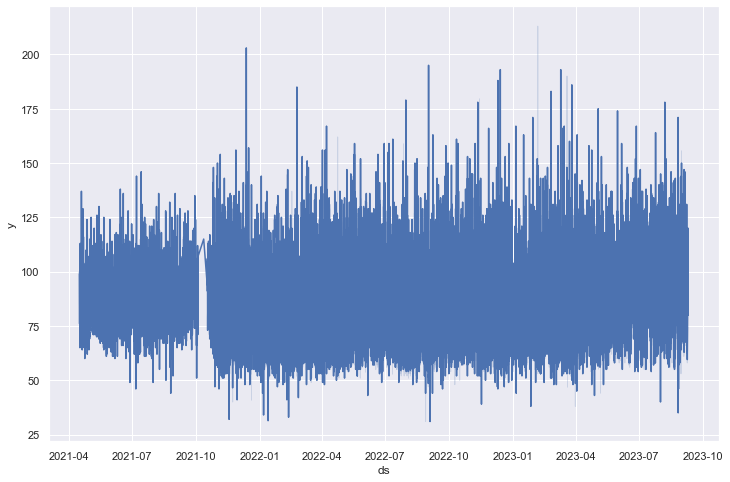

In [20]:
sns.set(rc = {'figure.figsize' : (12, 8)})
sns.lineplot(x = df['ds'], y = df['y'])

In [21]:
# train 데이터와 test 데이터 나누기
num_of_train = int(len(df)*0.8)
num_of_test = int(len(df)-num_of_train)

train = df[:num_of_train]
test = df[num_of_train:]

In [22]:
test1 = test[['ds']]
test1.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [23]:
test1.head()

,ds
0,2023-04-02 23:43:00
1,2023-04-02 23:55:00
2,2023-04-03 00:30:00
3,2023-04-03 00:30:00
4,2023-04-03 00:52:00


In [24]:
print(train.shape)
print(test.shape)

(53495, 2)
(13374, 2)


In [25]:
#help(Prophet)

In [27]:
model  = Prophet(interval_width = 0.95, weekly_seasonality = True) # yearly_seasonality = True
# interval_width : width of the uncertainty intervals provided for the forecast.

model.fit(train)

16:48:08 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# future = model.make_future_dataframe(periods=48)

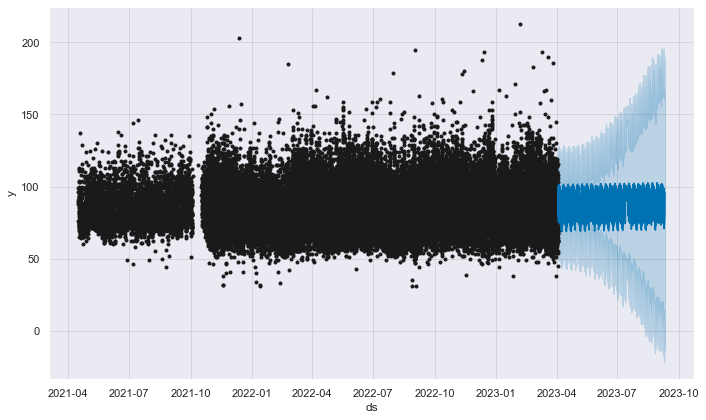

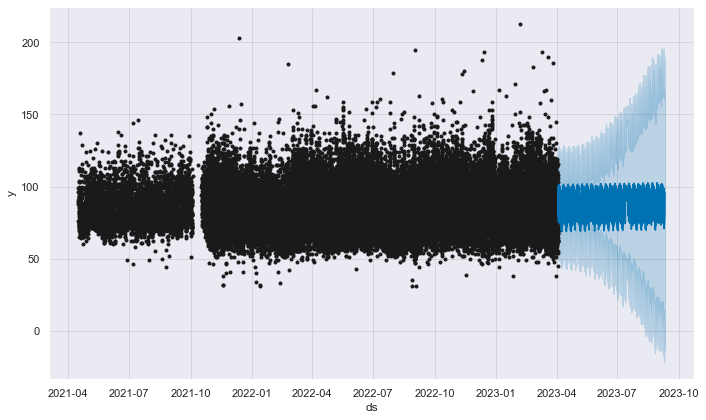

In [28]:
forecast = model.predict(test1)

model.plot(forecast)

In [29]:
performance = pd.merge(test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on = 'ds')

performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')

performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 8.89476055889963
The MAPE for the model is 0.10301672458032263


In [30]:
performance

,ds,y,yhat,yhat_lower,yhat_upper
0,2023-04-02 23:43:00,69,79.819035,57.069129,104.382116
1,2023-04-02 23:55:00,69,80.629136,54.797155,106.017639
2,2023-04-03 00:30:00,83,83.079407,58.033977,107.601518
3,2023-04-03 00:30:00,83,83.079407,56.599608,106.717302
4,2023-04-03 00:30:00,85,83.079407,58.033977,107.601518
...,...,...,...,...,...
17765,2023-09-10 04:20:00,105,95.356588,4.377196,183.497698
17766,2023-09-10 04:33:00,100,95.712041,7.619972,189.881731
17767,2023-09-10 04:40:00,99,95.867315,10.568107,183.959977
17768,2023-09-10 04:50:00,99,96.045506,8.926778,186.562408


In [31]:
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
performance['anomaly'].value_counts()

0    17530
1      240
Name: anomaly, dtype: int64

In [32]:
anomalies = performance[performance['anomaly']==1].sort_values(by = 'ds')

<AxesSubplot:xlabel='ds', ylabel='y'>

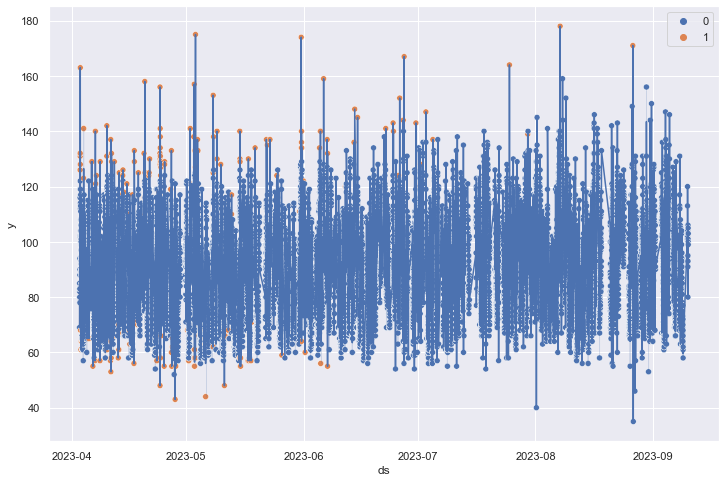

In [34]:
sns.scatterplot(x = 'ds', y = 'y', data = performance, hue = 'anomaly')
sns.lineplot(x = 'ds', y = 'y', data = performance)

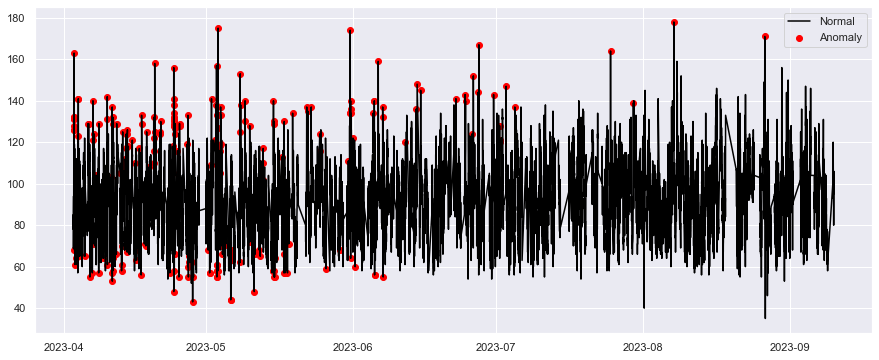

In [39]:
fig, ax = plt.subplots(figsize=(15,6))
a = performance.loc[performance['anomaly'] == 1] #anomaly
ax.plot(performance['ds'], performance['y'], color='black', label = 'Normal')
ax.scatter(a['ds'], a['y'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [36]:
pd.set_option('display.max_rows', None)
performance[performance['anomaly']==1]

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
22,2023-04-03 03:34:00,126,95.936435,71.278119,120.118480,1
23,2023-04-03 03:34:00,126,95.936435,71.352481,120.491645,1
24,2023-04-03 03:52:00,131,96.812432,70.718768,124.247559,1
25,2023-04-03 03:52:00,131,96.812432,72.778006,121.142534,1
26,2023-04-03 03:52:00,132,96.812432,70.718768,124.247559,1
27,2023-04-03 03:52:00,132,96.812432,72.778006,121.142534,1
29,2023-04-03 04:31:00,163,98.182040,73.084447,125.027240,1
30,2023-04-03 04:43:00,128,98.447202,74.276127,122.756041,1
38,2023-04-03 06:33:00,68,98.069449,72.571524,123.559887,1
52,2023-04-03 08:41:00,61,97.481779,73.780416,120.664487,1


In [37]:
performance[performance['y'] < 50]

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
2807,2023-04-24 04:21:00,48,98.064053,72.489186,121.760948,1
3265,2023-04-28 03:41:00,43,95.740539,67.540056,122.004942,1
4073,2023-05-06 04:15:00,44,93.310269,68.144404,119.166670,1
4074,2023-05-06 04:15:00,44,93.310269,66.371184,120.981218,1
4711,2023-05-11 03:00:00,48,94.815090,65.699907,121.770970,1
13471,2023-08-01 05:47:00,40,101.597027,39.503181,166.039708,0
16324,2023-08-26 17:51:00,35,76.231974,-1.547107,157.956531,0
16398,2023-08-27 04:23:00,46,95.339698,16.448555,177.792278,0
